# Modele liniowe

## Konfiguracja

Użyjemy standardowego stosu narzędzi do tabelarycznego uczenia maszynowego w Pythonie: Numpy, Pandas, Matplotlib i Scikit-learn. Użyjemy też missingno dla łatwej wizualizacji wartości brakujących.

In [6]:
!pip install numpy pandas matplotlib scikit-learn missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Zbiór danych do regresji

Wykorzystamy zbiór danych [Ames housing](https://www.openintro.org/book/statdata/?data=ames), w którym zadaniem jest przewidywanie wartości domu na podstawie cech budynku, działki, lokalizacji itp. Jest to więc przewidywanie wartości ciągłej, czyli regresja. Obejmuje zmienne do usunięcia (np. ID transakcji), numeryczne (floaty i inty), kategoryczne nieuporządkowane (*categorical nominal*) oraz kategoryczne uporządkowane (*categorical ordinal*), więc będzie wymagał wstępnego przetworzenia tak jak większość prawdziwych danych w ML.

Inne znane, ale gorsze jakościowo zbiory tego typu to na przykład:
- Boston housing - rasistowski, z tego powodu usunięty np. ze Scikit-learn ([wyjaśnienie](https://fairlearn.org/main/user_guide/datasets/boston_housing_data.html), [dyskusja](https://github.com/quantumblacklabs/causalnex/issues/92), [badanie](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8))
- California housing - zbyt prosty (tylko kilka zmiennych numerycznych), użyty np. w książce "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" A. Geron ([opis](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html))

Autor zbioru to Dean De Cock, a zbiór został opisany oryginalnie w [tym artykule](https://jse.amstat.org/v19n3/decock.pdf). Szczegółowe opisy zmiennych znajdują się w pliku `ames_description.txt`.

In [9]:
df = pd.read_csv("ames_data.csv")

# remove dots from names to match data_description.txt
df.columns = [col.replace(".", "") for col in df.columns]

df.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [10]:
df.shape

(2930, 82)

## Eksploracja danych, czyszczenie danych i inżynieria cech

Wstępne czyszczenie danych (*data cleaning*) obejmuje:
- usunięcie kolumn `Order` oraz `PID`
- usunięcie obserwacji odstających (*outliers*), które mają powyżej 4000 stóp kwadratowych (ok. 370 metrów kwadratowych) powierzchni
- usunięcie wpisów z dzielnic `GrnHill` oraz `Landmrk`, które obejmują w sumie zaledwie 3 domy
- transformacja logarytmiczna zmiennej zależnej (ceny domu)

To drugie jest motywowane wykresem przedstawionym poniżej. Zostało uznane za błąd już przez samego autora.

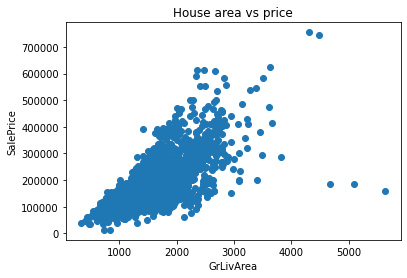

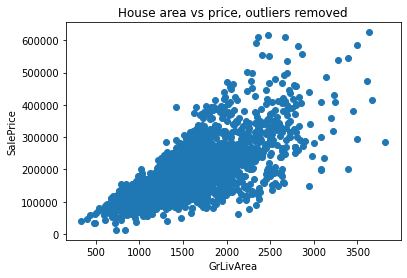

In [11]:
df = df.drop(["Order", "PID"], axis="columns")
df = df.loc[~df["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.title("House area vs price")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

df = df.loc[df["GrLivArea"] <= 4000, :]

plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.title("House area vs price, outliers removed")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [12]:
df = df.loc[df["GrLivArea"] <= 4000, :]

Zawsze warto też przyjrzeć się rozkładowi zmiennej docelowej, żeby poznać jego typ i skalę. Jak widać poniżej, rozkład jest dość skośny, co ma sens - mało jest bardzo drogich domów.

Rozkład normalny jest zwykle korzystniejszy dla tworzenia modeli, bo daje sensowną "wartość środkową" do przewidywania, a także penalizuje tak samo mylenie się w obie strony (zaniżona i zawyżona predykcja). Dokonamy dlatego **transformacji logarytmicznej (log transform)**, czyli zlogarytmujemy zmienną docelową (zależną). Dla stabilności numerycznej używa się zwykle `np.log1p`, a nie `np.log`.

Dodatkowa korzyść z takiej transformacji jest taka, że regresja liniowa przewiduje dowolne wartości rzeczywiste. Po przekształceniu logarytmicznym jest to całkowicie ok, natomiast w oryginalnej przestrzeni trzeba by wymusić przewidywanie tylko wartości pozytywnych (negatywne ceny są bez sensu). Da się to zrobić, ale zwiększa to koszt obliczeniowy. Operowanie na tzw. log-price jest bardzo częste w finansach.

**Uwaga:** - upewnij się, żeby nie wykonać komórki z kodem logarytmowania więcej niż raz, bo wtedy zlogarytmujesz wartości docelowe ponownie.

In [13]:
df["SalePrice"].describe()

count      2922.000000
mean     180358.266940
std       78536.952287
min       12789.000000
25%      129425.000000
50%      160000.000000
75%      213430.000000
max      625000.000000
Name: SalePrice, dtype: float64

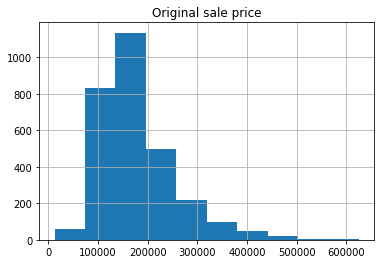

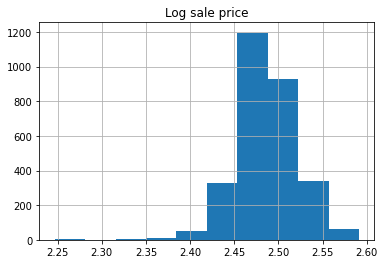

In [14]:
df["SalePrice"].hist()
plt.title("Original sale price")
plt.show()

df.loc[:, "SalePrice"] = np.log1p(df.loc[:, "SalePrice"])

pd.Series(np.log(df["SalePrice"])).hist()
plt.title("Log sale price")
plt.show()

W ramach **wstępnej eksploracji danych (Exploratory Data Analysis, EDA)** sprawdźmy też wartości brakujące. Są zmienne, które mają poniżej 10% wartości, a bardzo znacząca liczba cech ma co najmniej 10% braków.

<Axes: >

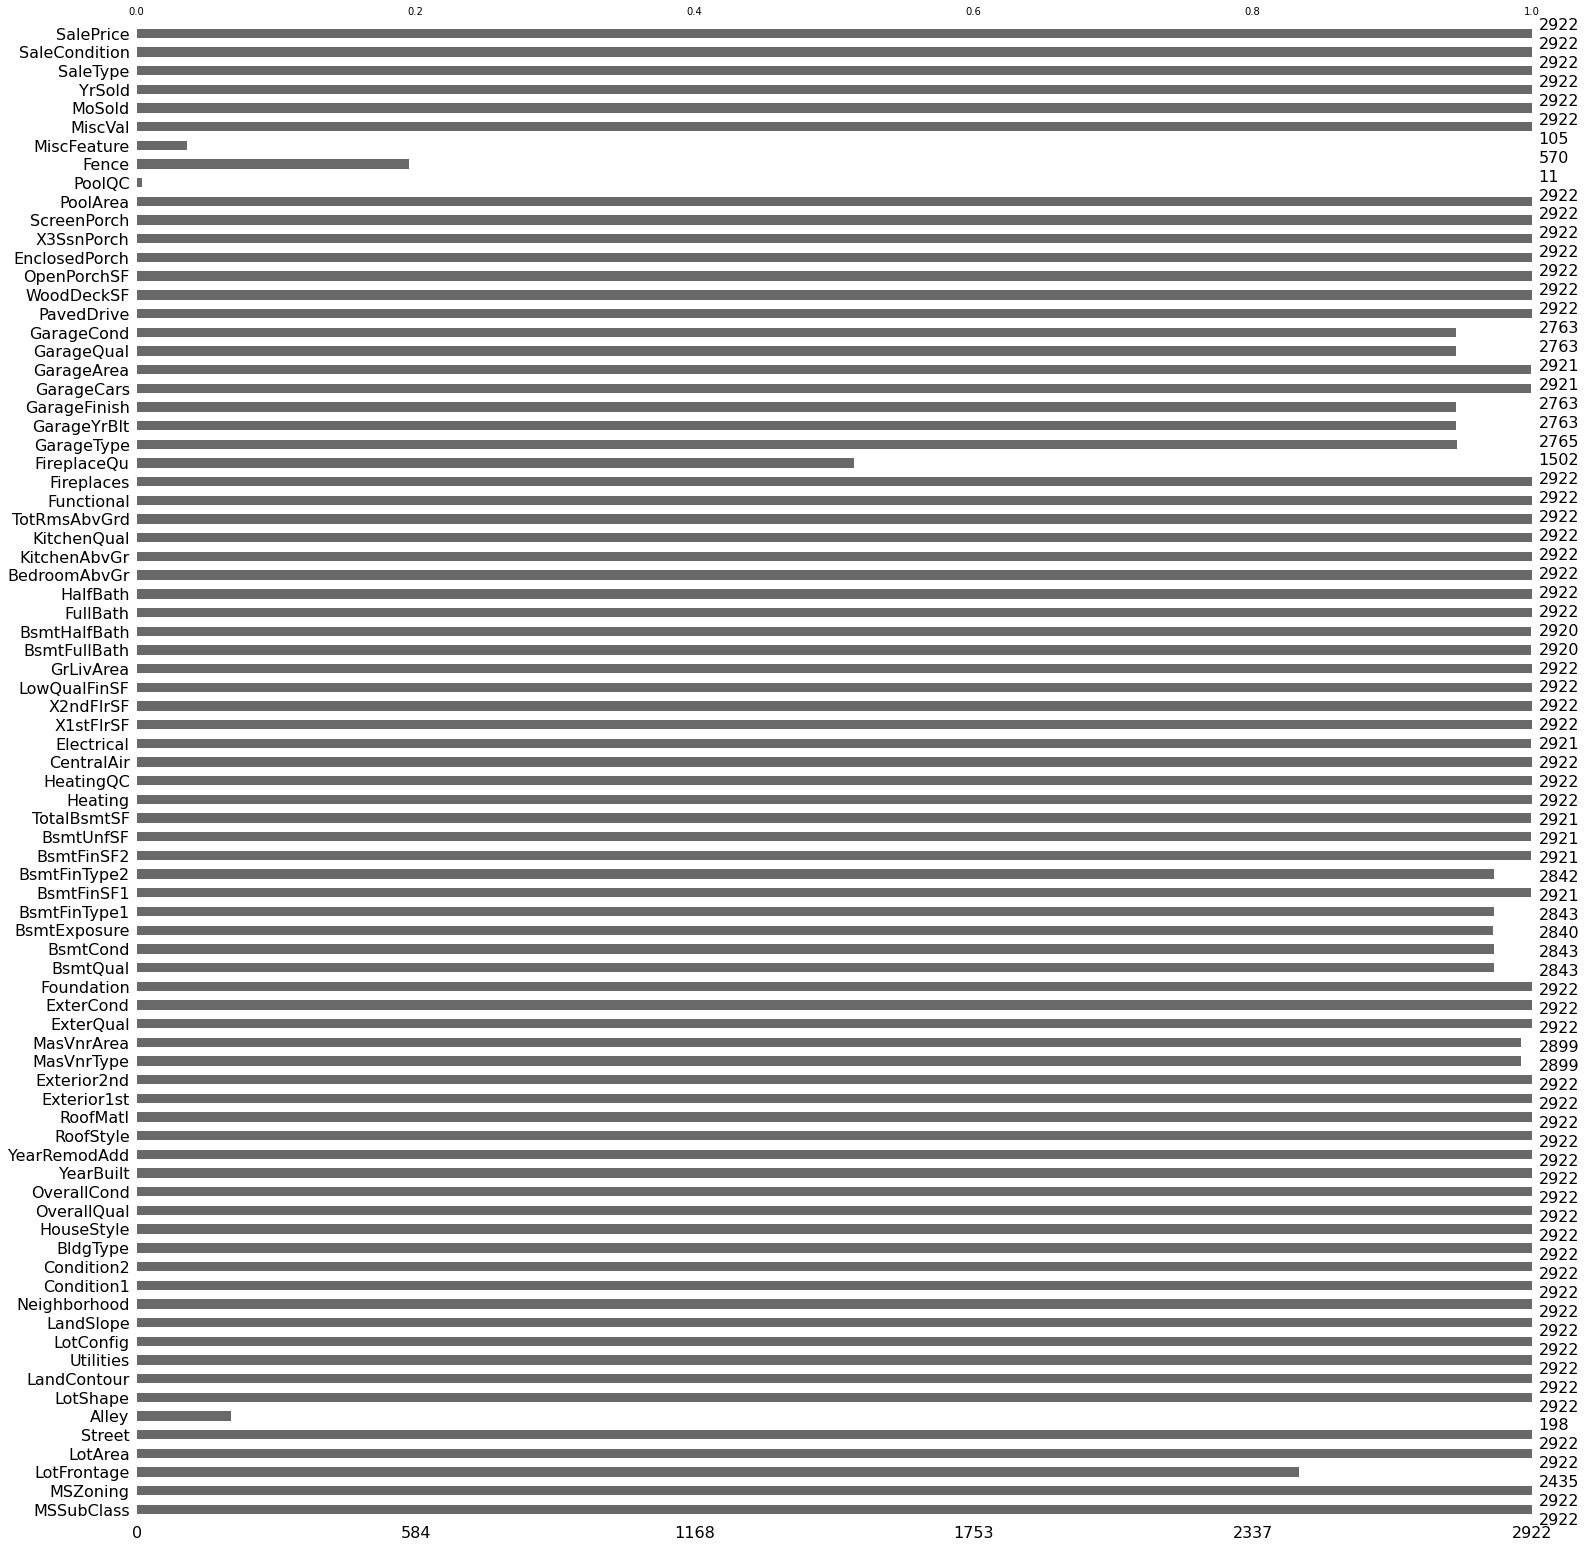

In [15]:
import missingno as msno

msno.bar(df)

W ramach dalszego czyszczenia danych uzupełnimy wartości brakujące. Trzeba tu jednak wziąć pod uwagę:
- mamy dużo zmiennych kategorycznych - nie można w nich dokonać imputacji modą, medianą itp.
- mamy często dużo wartości brakujących - estymacja modą byłaby niedokładna
- mamy dużą wiedzę o zmiennych dzięki plikowi z opisami

Można więc zastosować odpowiednią wiedzę i przyjąć wartości domyślne. Przykładowo, brak informacji o powierzchni piwnicy możemy uznać po prostu za brak piwnicy, i wpisać tam odpowiednią wartość. W przypadku niektórych zmiennych może doprowadzić to do stworzenia nowej wartości, która implicite będzie reprezentować wartość brakującą.

Znaczna część poniższej analizy została zainspirowana [tym notebookiem na Kaggle](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset).

In [16]:
def replace_na(df: pd.DataFrame, col: str, value) -> None:
    df.loc[:, col] = df.loc[:, col].fillna(value)

In [17]:
# Alley : data description says NA means "no alley access"
replace_na(df, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df, "BsmtQual", value="No")
replace_na(df, "BsmtCond", value="No")
replace_na(df, "BsmtExposure", value="No")
replace_na(df, "BsmtFinType1", value="No")
replace_na(df, "BsmtFinType2", value="No")
replace_na(df, "BsmtFullBath", value=0)
replace_na(df, "BsmtHalfBath", value=0)
replace_na(df, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df, "Condition1", value="Norm")
replace_na(df, "Condition2", value="Norm")

# External stuff : NA most likely means average
replace_na(df, "ExterCond", value="TA")
replace_na(df, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df, "GarageType", value="No")
replace_na(df, "GarageFinish", value="No")
replace_na(df, "GarageQual", value="No")
replace_na(df, "GarageCond", value="No")
replace_na(df, "GarageArea", value=0)
replace_na(df, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df, "MasVnrType", value="None")
replace_na(df, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df, "MiscFeature", value="No")
replace_na(df, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df, "PoolQC", value="No")
replace_na(df, "PoolArea", value=0)

# ScreenPorch : NA most likely means no screen porch
replace_na(df, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df, "WoodDeckSF", value=0)

**Zadanie 1 (0.5 punktu)**

Z pomocą dokumentacji zmiennych w pliku `data_description.txt` zdecyduj, jakie wartości domyślne przypisać zmiennym:
- `CentralAir`
- `EnclosedPorch`
- `FireplaceQu` oraz `Fireplaces`
- `SaleCondition`

W praktyce niestety zwykle nie jest tak różowo, że mamy dokumentację, i ten krok zajmuje kilka godzin (lub dni) u różnych osób w firmie :)

In [18]:
# NA most likely means there's no central air conditioning
replace_na(df, "CentralAir", value="No")

# NA most likely means 0
replace_na(df, "EnclosedPorch", value=0)

# NA means 0
replace_na(df, "FireplaceQu", value="No")
replace_na(df, "Fireplaces", value=0)

# NA probably means there's nothing special to them
replace_na(df, "SaleCondition", value="Normal")

W dalszej kolejności zamienimy zmienne `MSSubClass` i `MoSold` z numerycznych na kategoryczne, zgodnie z ich znaczeniem. Zakodujemy także zmienne kategoryczne uporządkowane (categorical ordinal) z tekstowych na kolejne liczby całkowite.

In [19]:
df = df.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

In [20]:
df = df.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

W Pandasie zmienne kategoryczne, napisy itp. są typu `object`, natomiast numeryczne mają typy z Numpy'a, np. `int64`. Oczywiście oba rodzaje zmiennych trzeba przetwarzać na inne sposoby, więc zapiszemy to od razu. Wyodrębnimy też wektor docelowy.

Od razu dokonamy też podziału na zbiór treningowy i testowy. Jako że nasz zbiór jest dość mały, to podział będzie 70%-30%.

In [21]:
from sklearn.model_selection import train_test_split

y = df.pop("SalePrice")

categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=0
)

Teraz trzeba dokonać transformacji naszych danych:
- zmienne kategoryczne trzeba zamienić na osobne kolumny - **one-hot encoding**
- zmienne numeryczne dalej mogą mieć wartości brakujące i trzeba je **imputować (impute**)
- zmienne numeryczne trzeba przeskalować do zakresu wartości $[0, 1]$ - **normalization / min-max scaling**

Mamy zatem 2 operacje do wykonania na zmiennych numerycznych po kolei (imputacja + skalowanie), a równolegle 1 na kategorycznych. Służą do tego w Scikit-learn'ie klasy:
- `OneHotEncoder`, `SimpleImputer`, `MinMaxScaler` - transformacje, implementują `.fit()` i `.transform()`
- `Pipeline` - do układania transformacji sekwencyjnie
- `ColumnTransformer` - do układania transformacji równolegle, dla różnych kolumn

**Ważne:** jako że zaraz skorzystamy z regresji liniowej, do klasy `OneHotEncoder` trzeba przekazać `drop="first"`. Stworzy to 1 zmienną mniej, niż typowy one-hot encoding, np. `pd.get_dummies()`, gwarantując brak **idealnie współliniowych zmiennych (perfectly collinear features)**, który byłby niestabilny numerycznie. Dodatkowo, jako że przekształcamy już po podziale na zbiór treningowy i testowy, to możemy spotkać na zbiorze testowym nieliczne przypadki kategorii, których nie ma w zbiorze treningowym - kodujemy je wtedy po prostu jako zera za pomocą `handle_unknown="ignore"`.

**Zadanie 2 (0.5 punktu)**

Stwórz pipeline'y dla zmiennych kategorycznych i numerycznych. Połącz je następnie z użyciem `ColumnTransformer`. "Wytrenuj" go na danych treningowych, a następnie przetransformuj dane treningowe oraz testowe.

In [22]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', '

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


one_hot_encoder = OneHotEncoder(
    drop="first", sparse_output=False, handle_unknown="ignore"
)
median_imputer = SimpleImputer(strategy="median")
min_max_scaler = MinMaxScaler()

categorical_pipeline =  Pipeline([('encoder', one_hot_encoder)])

numerical_pipeline = Pipeline([('imputer', median_imputer), ('scaler', min_max_scaler)])

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features),
        ('num', numerical_pipeline, numerical_features)
    ]
)

# fit and transform

column_transformer.fit(X_train)

X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12, 15, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Regresja liniowa

Możemy teraz przejść do przewidywania wartości domów. Naszym narzędziem będzie tutaj **regresja liniowa (linear regression)**, czyli model postaci:
$$
\hat{y} = w \cdot x = \sum_{i=1}^{d} w_i x_i
$$
gdzie $n$ to liczba punktów w zbiorze, a $d$ to wymiarowość. Zakładamy też dodanie punktu przecięcia ze środkiem układu współrzędnych (*bias / intercept*) jako stałej cechy samych jedynek.

Jako że używamy wielu zmiennych, to formaliści nazwaliby ten model wielokrotną regresją liniową (*multiple linear regression*), w odróżnieniu od prostej regresji liniowej (*simple linear regression*), która używa tylko 1 cechy. Takie rozróżnienie jest bardziej typowe dla nauk, które wykorzystują regresję głównie do analizy statystycznej, a nie predykcji, jak np. biologia czy medycyna.

Model ten minimalizuje **błąd średniokwadratowy (mean squared error, MSE)**:
$$
L(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n \left( y - \hat{y} \right)^2
$$

W Scikit-learn ten model implementuje klasa `LinearRegression`. Ważne cechy:
- domyślnie uwzględnia intercept (bias) przez `fit_intercept=True`; jest to niepotrzebne i może powodować problemy numeryczne, kiedy nasze dane są już wycentrowane
- używa implementacji z pseudoodwrotnością Moore'a-Pendrose'a (SVD)
- nie pozwala na regularyzację, do tego trzeba użyć innych klas

Sprawdźmy, jak taki model sobie radzi. Do ewaluacji będziemy używać **Root MSE (RMSE)**, czyli pierwiastka kwadratowego z MSE. Ma ważne zalety:
- regresja liniowa z definicji modelu opiera się o MSE, więc używamy metryki dobrze związanej z modelem
- ma tę samą jednostkę, co przewidywane wartości, dzięki pierwiastkowaniu
Jest też dość czuła na outliery, ale może to być korzystne, w zależności od zastosowania.

$$
RMSE(y, \hat{y}) = \sqrt{\sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

W Scikit-learn RMSE liczy się dość specyficznie, bo używa się funkcji do MSE z argumentem `squared=False`.

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# all variables are in range [0, 1], so we don't need an intercept
reg_linear = LinearRegression(fit_intercept=False)
reg_linear.fit(X_train, y_train)

y_pred = reg_linear.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"RMSE: {rmse:.4f}")

RMSE: 0.1159


Czy taki błąd to duży, czy mały błąd? Wszystko zależy od skali wartości przewidywanych. Trzeba pamiętać, że dokonaliśmy logarytmowania zmiennej docelowej, więc trzeba to sprawdzić po transformacji odwrotnej `np.expm1`. Po tej operacji jednostką będą oryginalne dolary.

Dodatkowo trzeba zweryfikować, czy przeuczamy (overfitujemy). Sprawdza się to następująco:
- obliczamy błąd treningowy oraz testowy
- jeżeli oba błędy są wysokie, to mamy underfitting i trzeba użyć pojemniejszego modelu
- jeżeli błąd treningowy jest dużo niższy od testowego, to mamy overfitting i trzeba regularyzować

W praktyce paradoksalnie często model o większej pojemności z mocną regularyzacją działa lepiej od prostszego modelu ze słabą regularyzacją.

**Zadanie 3 (0.5 punktu)**

Uzupełnij kod funkcji `assess_regression_model`:
- obliczenie predykcji treningowych oraz testowych
- transformacje eksponencjalne, żeby wrócić do oryginalnej jednostki (dolara)
- obliczenie RMSE treningowego i testowego
- wypisywanie RMSE, zoakrąglonego do 2 miejsc po przecinku

Użyj następnie tej funkcji, aby ocenić, czy następuje overfitting, skomentuj to poniżej. Oceń także, czy subiektywnie to duża wartość, biorąc pod uwagę rozkład zmiennej docelowej (wartości i wykresy w sekcji EDA).

In [25]:
def assess_regression_model(model, X_train, X_test, y_train, y_test) -> None:
    # predict for train and test
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # exponential transform for y_train, y_test and predictions
    train_pred = np.expm1(train_pred)
    test_pred = np.expm1(test_pred)

    # calculate train and test RMSE
    train_rmse = mean_squared_error(np.expm1(y_train), train_pred, squared=False)
    test_rmse = mean_squared_error(np.expm1(y_test), test_pred, squared=False)
    
    # print train and test RMSE
    print("train rmse", train_rmse)
    print("test_rmse", test_rmse)


In [26]:
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test)

train rmse 16751.114707789355
test_rmse 21318.61460646117


Jak widać train_rsme i test_rmse są wysokie i bardzo do siebie zbliżone. Regresja liniowa to zbyt mało pojemny model.

## Regresja regularyzowana (ridge, LASSO)

Regularyzacja zmniejsza pojemność modelu regresji liniowej, narzucając mniejsze wagi poprzez penalizację dużych wag w funkcji kosztu:
$$
L_{ridge}(y, \hat{y}) = \frac{1}{n} (y - \hat{y})^2 + \lambda ||w||_2^2 \\
L_{LASSO}(y, \hat{y}) = \frac{1}{n} (y - \hat{y})^2 + \alpha ||w||_1 \\
L_{ElasticNet}(y, \hat{y}) = \frac{1}{n} (y - \hat{y})^2 + \lambda ||w||_2^2 + \alpha ||w||_1 \\
$$

Regresja ridge zmniejsza wagi i jest różniczkowalna (szybsza i łatwiejsza w treningu), natomiast regresja LASSO dokonuje selekcji cech, zmniejszając często wagi cech dokładnie do zera. Oba naraz realizuje model ElasticNet.

W Scikit-learn implementują je klasy `Ridge`, `Lasso` oraz `ElasticNet`. Najważniejszy hiperparametr każdego z tych modeli to siła regularyzacji, która we wszystkich klasach to `alpha`. Scikit-learn definiuje regularyzację ElasticNet dość specyficznie, za pomocą parametru `l1_ratio`, który wyznacza, jaki ułamek siły regularyzacji przypada dla L1, a jaki dla L2:
$$
L_{ElasticNet}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n \left( y - \hat{y} \right)^2 + \alpha \cdot (1 - L1\_ratio) \cdot ||w||_2^2 + \alpha \cdot L1\_ratio \cdot ||w||_1 \\
$$

Inne ważne uwagi:
- liczba iteracji `max_iter` wyznacza liczbę iteracji solwera; im więcej, tym dokładniejsze rozwiązanie, ale tym dłuższy czas obliczeń
- jeżeli `max_iter` będzie zbyt małe i algorytm nie osiągnie zbieżności, to dostaniemy ostrzeżenie, wtedy zwykle trzeba po prostu ją zwiększyć, np. 10-krotnie
- jeżeli nie potrzebujemy bardzo precyzyjnego rozwiązania, można ustawić większe `tol` dla przyspieszenia obliczeń

Jako że nasz model jest regularyzowany i nie ma ryzyka problemów numerycznych, to teraz już obliczamy intercept.

In [27]:
from sklearn.linear_model import Ridge, Lasso

reg_ridge = Ridge(random_state=0)
reg_lasso = Lasso(random_state=0)

reg_ridge.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)

assess_regression_model(reg_ridge, X_train, X_test, y_train, y_test)
print()
assess_regression_model(reg_lasso, X_train, X_test, y_train, y_test)

train rmse 16870.91199423655
test_rmse 18879.105240626544

train rmse 79579.7870177079
test_rmse 80091.98682467625


W przypadku regularyzacji L2 domyślna siła regularyzacji (`alpha=1.0`) znacząco poprawiła wynik, natomiast w przypadku L1 mamy silny underfitting. Przyda się zastosować tutaj tuning hiperparametrów.

W przypadku regresji liniowej istnieją bardzo wydajne implementacje walidacji skrośnej, głównie dzięki prostocie tego modelu. W Scikit-learn są to odpowiednio `RidgeCV`, `LassoCV` oraz `ElasticNetCV`.

`RidgeCV` domyślnie wykorzystuje efektywną implementację Leave-One-Out Cross-Validation (LOOCV), w którym zbiorem walidacyjnym jest w danej chwili jedna próbka. Jest to możliwe dzięki pewnym sztuczkom opartym na algebrze liniowej, wyjaśnionych [w dokumentacji w kodzie](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b7e21201cfffb118934999025fd50cca/sklearn/linear_model/_ridge.py#L1547) (dla zainteresowanych). Co ważne, jest to operacja o wiele szybsza niż osobne grid search + ridge regression, a nawet od `RidgeCV` z mniejszą liczbą foldów.

`LassoCV` oraz `ElasticNetCV` iterują od najmniejszych do największych wartości `alpha` (siły regularyzacji), używając rozwiązania dla mniejszej siły regularyzacji jako punktu początkowego dla kolejnej wartości. Odpowiada to po prostu dość inteligentnemu wyborowi punktu startowego w optymalizacji funkcji kosztu, a znacznie obniża koszt obliczeniowy.

**Zadanie 4 (0.5 punktu)**

Użyj klas `RidgeCV` oraz `LassoCV` do tuningu hiperparametrów.

Dla `RidgeCV` sprawdź 1000 wartości `[0.1, 100]` w skali liniowej - przyda się `np.linspace()`. Użyj LOOCV.

Dla `LassoCV` Scikit-learn sam dobierze wartości, musisz podać tylko liczbę wartości alfa do sprawdzenia - użyj 1000. Użyj 5-fold CV. Pamiętaj o podaniu `random_state=0` - solwer jest niedeterministyczny.

Wypisz znalezione optymalne wartości siły regularyzacji `.alpha_` dla obu modeli, zaokrąglone do 4 miejsca po przecinku dla czytelności.

Przetestuj modele z użyciem `assess_regression_model()`. Skomentuj wyniki. Czy udało się wyeliminować overfitting?

In [28]:
from sklearn.linear_model import RidgeCV

alphas = np.linspace(0.1, 100, 1000)
reg_ridge_cv = RidgeCV(alphas=alphas)
reg_ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([  0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,   0.9,
         1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,   1.8,
         1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,
         3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,   4.4,   4.5,
         4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,   5.3,   5.4,
         5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.1,   6.2,   6.3,
         6.4,   6.5,   6.6,   6.7,   6.8,   6.9,   7. ,   7.1,   7.2,
         7.3,   7.4,   7.5,   7.6,   7.7,   7.8,   7.9,   8. ,   8.1,
         8.2,   8.3,   8.4,...
        92.8,  92.9,  93. ,  93.1,  93.2,  93.3,  93.4,  93.5,  93.6,
        93.7,  93.8,  93.9,  94. ,  94.1,  94.2,  94.3,  94.4,  94.5,
        94.6,  94.7,  94.8,  94.9,  95. ,  95.1,  95.2,  95.3,  95.4,
        95.5,  95.6,  95.7,  95.8,  95.9,  96. ,  96.1,  96.2,  96.3,
        96.4,  96.5,  96.6,  96.7,  96.8,  96.9,  97. ,  97.1,  97.2,
        97.3,  97.4,  97.5,  97.6,  97.7,  97.8,  97.9,  98. ,  98.1,
        98.2,  98.3,  98.4,  98.5,  98.6,  98.7,  98.8,  98.9,  99. ,
        99.1,  99.2,  99.3,  99.4,  99.5,  99.6,  99.7,  99.8,  99.9,
       100. ]))

In [29]:
from sklearn.linear_model import LassoCV

reg_lasso_cv = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

In [30]:
assess_regression_model(reg_ridge_cv, X_train, X_test, y_train, y_test)
print()
assess_regression_model(reg_lasso_cv, X_train, X_test, y_train, y_test)

train rmse 17212.412656165707
test_rmse 18758.434421864782

train rmse 18074.219132299375
test_rmse 18649.709105623795


Ridge niewiele się poprawił, ponieważ alpha=1.0 był w miarę dobrze dopasowanym parametrem. Widzimy natomiast dużą poprawę dla Lasso(zmniejszylismy underfitting), który nawet w tym momencie daje lepsze wyniki dla danych testowych niż ridge. 

Sprawdźmy teraz, jak zmieniły się maksymalne wielkości współczynników (w sensie wartości bezwzględnej) dla cech dla regularyzacji L2, oraz ile cech zostało wyeliminowanych przez regularyzację L1.

**Uwaga:** kod zakłada, że zmienne to `reg_ridge_cv` oraz `reg_lasso_cv`. Jeżeli u ciebie są inne, dostosuj poniższy kod.

In [31]:
coeffs_linear_max = np.max(np.abs(reg_linear.coef_))
coeffs_ridge_max = np.max(np.abs(reg_ridge.coef_))
coeffs_ridge_cv_max = np.max(np.abs(reg_ridge_cv.coef_))

coeffs_linear_zero_perc = np.sum(reg_linear.coef_ == 0) / len(reg_linear.coef_)
coeffs_lasso_zero_perc = np.sum(reg_lasso.coef_ == 0) / len(reg_linear.coef_)
coeffs_lasso_cv_zero_perc = np.sum(reg_lasso_cv.coef_ == 0) / len(reg_linear.coef_)

print("Coefficients magnitudes (linear, ridge, ridge with CV)")
print(
    f"Max: {coeffs_linear_max:.2f} vs",
    f"vs {coeffs_ridge_max:.2f} vs",
    f"{coeffs_ridge_cv_max:.2f}",
)
print()
print("Percentage of eliminated features (linear, LASSO, LASSO with CV)")
print(
    f"{100 * coeffs_linear_zero_perc:.2f}% vs",
    f"{100 * coeffs_lasso_zero_perc:.2f}% vs",
    f"{100 * coeffs_lasso_cv_zero_perc:.2f}%",
)

Coefficients magnitudes (linear, ridge, ridge with CV)
Max: 818.07 vs vs 0.52 vs 0.45

Percentage of eliminated features (linear, LASSO, LASSO with CV)
0.00% vs 100.00% vs 53.85%


**Zadanie 5 (0.5 punktu)**

Dokonaj interpretacji zmian we współczynnikach dla regresji ridge oraz LASSO. Zauważ też, że LASSO bez tuningu hiperparametrów wyeliminowało wszystkie cechy, a my nie trenujemy punktu przecięcia (intercept). Co oznacza taki model?

# **Mój komentarz**

W porównaniu ze zwykłą regresją liniową ridge mocno ogranicza wagi współczynników(818 vs 0.5) o bardzo dużą wartość, taki model działa lepiej ponieważ zwykle wysokie wagi przy współczynnikach negatywnie wpływają na jakość modelu. Odnośnie lasso to nic dziwnego, że wyeliminowanie wszystkich współczynników skutkuje słabym modelem 😀. Skoro nie trenujemy punktu przecięcia, to czy regresja "wytrenowana" przez lasso to nie jest losowo wygenerowana płaszczyzna?(nie jestem pewien). Po tuningu hiperparametrów lasso zostawiło około połowę współczynników w modelu i teraz daje lepsze wyniki niż ridge.

Warto zwrócić uwagę, że zbieranie i obliczanie cech jest często drogie w praktyce. W tym przypadku model z mniejszą ilością cech dodatkowo radzi sobie dobrze, więc jest tańszy i prostszy, są to znaczące zalety. Zawsze warto się przyjrzeć temu, co model uznaje za bardzo wartościowe oraz mało wartościowe cechy, bo daje nam to wiedzę, na czym się skupić w przyszłości.

Jako że dokonaliśmy wcześniej wielu transformacji, to nazwy kolumn są dość mocno poprzekształcane. Na szczęście wszystkie obiekty transformujące w Scikit-learn (z metodą `.transform()`) implementują też metodę `.get_feature_names_out()`.

In [32]:
column_transformer.get_feature_names_out()

array(['cat__MSSubClass_SC150', 'cat__MSSubClass_SC160',
       'cat__MSSubClass_SC180', 'cat__MSSubClass_SC190',
       'cat__MSSubClass_SC20', 'cat__MSSubClass_SC30',
       'cat__MSSubClass_SC40', 'cat__MSSubClass_SC45',
       'cat__MSSubClass_SC50', 'cat__MSSubClass_SC60',
       'cat__MSSubClass_SC70', 'cat__MSSubClass_SC75',
       'cat__MSSubClass_SC80', 'cat__MSSubClass_SC85',
       'cat__MSSubClass_SC90', 'cat__MSZoning_C (all)',
       'cat__MSZoning_FV', 'cat__MSZoning_I (all)', 'cat__MSZoning_RH',
       'cat__MSZoning_RL', 'cat__MSZoning_RM', 'cat__LandContour_HLS',
       'cat__LandContour_Low', 'cat__LandContour_Lvl',
       'cat__LotConfig_CulDSac', 'cat__LotConfig_FR2',
       'cat__LotConfig_FR3', 'cat__LotConfig_Inside',
       'cat__Neighborhood_Blueste', 'cat__Neighborhood_BrDale',
       'cat__Neighborhood_BrkSide', 'cat__Neighborhood_ClearCr',
       'cat__Neighborhood_CollgCr', 'cat__Neighborhood_Crawfor',
       'cat__Neighborhood_Edwards', 'cat__Neighborhood

**Zadanie 6 (0.75 punktu)**

Wyczyść nazwy cech, usuwając z nich przedrostek "num_pipeline__" oraz "cat_pipeline__".

Następnie narysuj poziomy wykres słupkowy 10 najważniejszych cech według regresji LASSO po tuningu. Wartościami mają być współczynniki cech. Użyj nazw cech do opisu wykresu. Zadbaj o odpowiedni tytuł.

Wypisz także posortowaną listę nazw wyeliminowanych cech.

Dokonaj interpretacji 2 wybranych cech spośród najlepszych oraz 2 wybranych spośród tych wyeliminowanych - przyda się dokumentacja do zbioru danych. Czy ta ocena dokonana przez model ma twoim zdaniem sens?

Przydatna może być zamiana z `np.ndarray` na `pd.Series`, argument `key` w metodzie `.sort_values()`, oraz metoda `.plot.barh()`.

In [33]:
feature_names = column_transformer.get_feature_names_out()
feature_names = [s.replace('cat__', '') for s in feature_names]
feature_names = [s.replace('num__', '') for s in feature_names]
feature_names = pd.Series(feature_names)

In [34]:
importance = np.abs(reg_lasso_cv.coef_)
importance

array([0.00000000e+00, 5.09329143e-02, 0.00000000e+00, 0.00000000e+00,
       1.42195365e-02, 3.21359039e-02, 0.00000000e+00, 0.00000000e+00,
       8.23128488e-03, 0.00000000e+00, 3.03993249e-02, 0.00000000e+00,
       0.00000000e+00, 1.06958927e-02, 3.60809502e-02, 1.28883365e-01,
       5.39384485e-02, 0.00000000e+00, 0.00000000e+00, 6.36875740e-02,
       0.00000000e+00, 1.57762301e-02, 0.00000000e+00, 0.00000000e+00,
       8.39880449e-03, 1.22699318e-02, 0.00000000e+00, 3.68064974e-04,
       0.00000000e+00, 0.00000000e+00, 4.07034438e-02, 3.09220871e-02,
       3.79998649e-03, 9.27757017e-02, 1.71388447e-02, 0.00000000e+00,
       0.00000000e+00, 1.23033225e-02, 5.54911047e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.13606080e-04, 3.00840297e-02,
       5.70297956e-02, 1.52734518e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.62915850e-02, 6.72174116e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.87717467e-02, 2.10964493e-02,
      

In [35]:
zero_features = np.argwhere(importance == 0)[:-1].flatten()
zero_features_names = feature_names[zero_features]
print(zero_features_names)

0      MSSubClass_SC150
2      MSSubClass_SC180
3      MSSubClass_SC190
6       MSSubClass_SC40
7       MSSubClass_SC45
             ...       
215        TotRmsAbvGrd
222          GarageQual
228          X3SsnPorch
230            PoolArea
231              PoolQC
Length: 125, dtype: object


In [36]:
idx_features = (-importance).argsort()[:10]
idx_features
important_features_names = feature_names[idx_features]
important_features_names

207           GrLivArea
187         OverallQual
188         OverallCond
181             LotArea
216          Functional
202         TotalBsmtSF
198          BsmtFinSF1
189           YearBuilt
15     MSZoning_C (all)
132        Heating_Wall
dtype: object

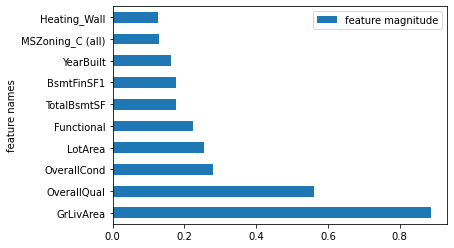

In [37]:
df = pd.DataFrame({'feature names': important_features_names, 'feature magnitude': importance[idx_features]})
ax = df.plot.barh(x='feature names', y='feature magnitude')

Nic dziwnego, GrLivArea jest najbardziej znaczącym czynnikiem, bo oznacza powierzchnię użytkową mieszkania, a im mieszkanie większe tym droższe. OverallQual oznacza ogólną jakość wykończenia, co również jest całkiem uniwersalnym wyznacznikiem jakości mieszkania, więc nie dziwię się, że jest drugie pod względem wagi.

## Regresja wielomianowa

Regresja wielomianowa to po prostu dodanie wielomianów cech do naszych danych:
$$
[a, b, c, d] -> [a, b, c, d, a^2, b^2, c^2, d^2, ab, ac, ad, bc, bd, cd]
$$

W Scikit-learn regresja wielomianowa składa się z 2 osobnych kroków: wygenerowania cech wielomianowych i użycia zwykłej regresji liniowej. Pozwala to na użycie tej transformacji dla dowolnych algorytmów, nie tylko regresji liniowej.

Kwestią sporną jest, czy jest sens przeprowadzać taką transformację dla zmiennych po one-hot encodingu. Potęgi na pewno nie mają sensu, natomiast interakcje realizują po prostu operację koniunkcji (AND), ale łatwo prowadzi to do eksplozji wymiarowości. Dla uproszczenia poniżej zastosujemy transformację dla wszystkich cech.

Warto pamiętać, że jeżeli używamy modelu, który sam dodaje intercept (jak regresja liniowa), to trzeba przekazać `include_bias=False`. Żeby wymiarowość nam nie urosła zbyt bardzo, użyjemy `interaction_only=True`.

In [38]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features.fit(X_train)

X_train_poly = poly_features.transform(X_train)
X_test_poly = poly_features.transform(X_test)

reg_ridge_cv_poly = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_ridge_cv_poly.fit(X_train_poly, y_train)

assess_regression_model(reg_ridge_cv_poly, X_train_poly, X_test_poly, y_train, y_test)
print()
print(f"Ridge + polynomial features alpha: {reg_ridge_cv_poly.alpha_:.4f}")

train rmse 12856.878895016644
test_rmse 18298.30197590184

Ridge + polynomial features alpha: 84.8000


Co ciekawe, model bardziej zbliżył się do przeuczenia, ale błąd testowy zmalał. Jest to niezbyt częste, ale możliwe.

## Regresja logistyczna

Do klasyfikacji wykorzystamy zbiór [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/bank+marketing), w którym przewiduje się, czy dana osoba będzie zainteresowana lokatą terminową w banku. Precyzyjny targetowany marketing jest ważny z perspektywy biznesu, bo w praktyce chce się reklamować tak mało, jak to możliwe. Bank zarabia tylko na tych osobach, które są faktycznie zainteresowane reklamą, a pozostałych można łatwo zrazić zbyt dużą liczbą reklam, więc precyzyjna ocena przynosi tu realne zyski.

Zbiór posiada dwie wersje, uproszczoną oraz rozszerzoną o dodatkowe atrybuty socjoekonomiczne (np. sytuację ekonomiczną w planowanym momencie reklamy). Wykorzystamy tę drugą, bo są to bardzo wartościowe cechy. Dodatkowo każda wersja posiada pełen zbiór (ok. 45 tysięcy przykładów) oraz pomniejszony (ok. 4 tysiąca przykładów). Dzięki skalowalności regresji logistycznej możemy bez problemu wykorzystać pełny zbiór z dodatkowymi cechami.

Opisy zmiennych znajdują się w pliku `bank_marketing_description.txt`.

**Zadanie 7 (1 punkt)**

*Wczytywanie i czyszczenie danych*

1. Załaduj zbiór danych z pliku `bank_marketing_data.csv` do DataFrame'a. Zwróć uwagę, że separatorem jest średnik (argument `sep`).
2. Usuń kolumny:
  - `default`, czy klient ma zadłużenie na karcie kredytowej; ma tylko 3 wartości `yes`
  - `duration`, czas trwania ostatniego telefonu reklamowego; autorzy sugerują usunięcie w opisie zbioru, bo nie znamy tej wartości przed wykonaniem telefonu
  - `pdays`, liczba dni od ostatniego telefonu reklamowego w ramach danej kampanii marketingowej; jeżeli to pierwszy kontakt, to wartość to 999, i ciężko byłoby włączyć taką cechę do modelu, a mamy już i tak informację o tym, czy to pierwszy kontakt z klientem w zmiennej `previous`
  - `poutcome`, wynik poprzedniej kampanii; w zdecydowanej większości przypadków to `nonexistent`
3. Dokonaj filtrowania wierszy:
  - usuń wiersze z `education` na poziomie `illiterate`, jest ich tylko kilkanaście
4. Zakoduj odpowiednio zmienne `education`, `contact`, `month`, `day_of_week` i `y`. Dla ułatwienia słowniki są w zmiennych poniżej.
5. Wyodrębnij kolumnę `y` do zmiennej `y` (pamiętaj o usunięciu jej z DataFrame'a).

In [39]:
education_mapping = {
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "primary",
    "high.school": "secondary",
    "professional.course": "secondary",
    "university.degree": "tertiary",
}

contact_mapping = {
    "telephone": 0,
    "cellular": 1,
}

month_mapping = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12,
}

day_of_week_mapping = {
    "mon": 1,
    "tue": 2,
    "wed": 3,
    "thu": 4,
    "fri": 5,
}

y_mapping = {
    "no": 0,
    "yes": 1,
}

In [40]:
df = pd.read_csv("/content/drive/MyDrive/bank_marketing_data.csv", sep=';') 
df.columns = [col.replace(".", "") for col in df.columns]

df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'empvarrate', 'conspriceidx', 'consconfidx',
       'euribor3m', 'nremployed', 'y'],
      dtype='object')

In [41]:
df = df.drop(["poutcome", "pdays", "duration", "default"], axis="columns")
df = df.loc[~df["education"].isin(["illiterate"]), :]

In [42]:
df = df.replace({
    "education": education_mapping,
    "contact": contact_mapping,
    "month": month_mapping,
    "day_of_week": day_of_week_mapping,
    "y": y_mapping
})

In [43]:
y = df.pop("y")

**Zadanie 8 (0.5 punktu)**

*Exploratory Data Analysis (EDA)*

1. Sprawdź, czy są jakieś wartości brakujące za pomocą biblioteki `missingno`. Jeżeli tak, to sprawdź w dokumentacji zbioru, jaka byłaby sensowna wartość do ich uzupełnienia.
2. Narysuj wykres (bar plot) z częstością klas. Uwzględnij częstość na wykresie ([to może się przydać](https://stackoverflow.com/a/68107610/9472066)). Pamiętaj o tytule i opisaniu osi.

<Axes: >

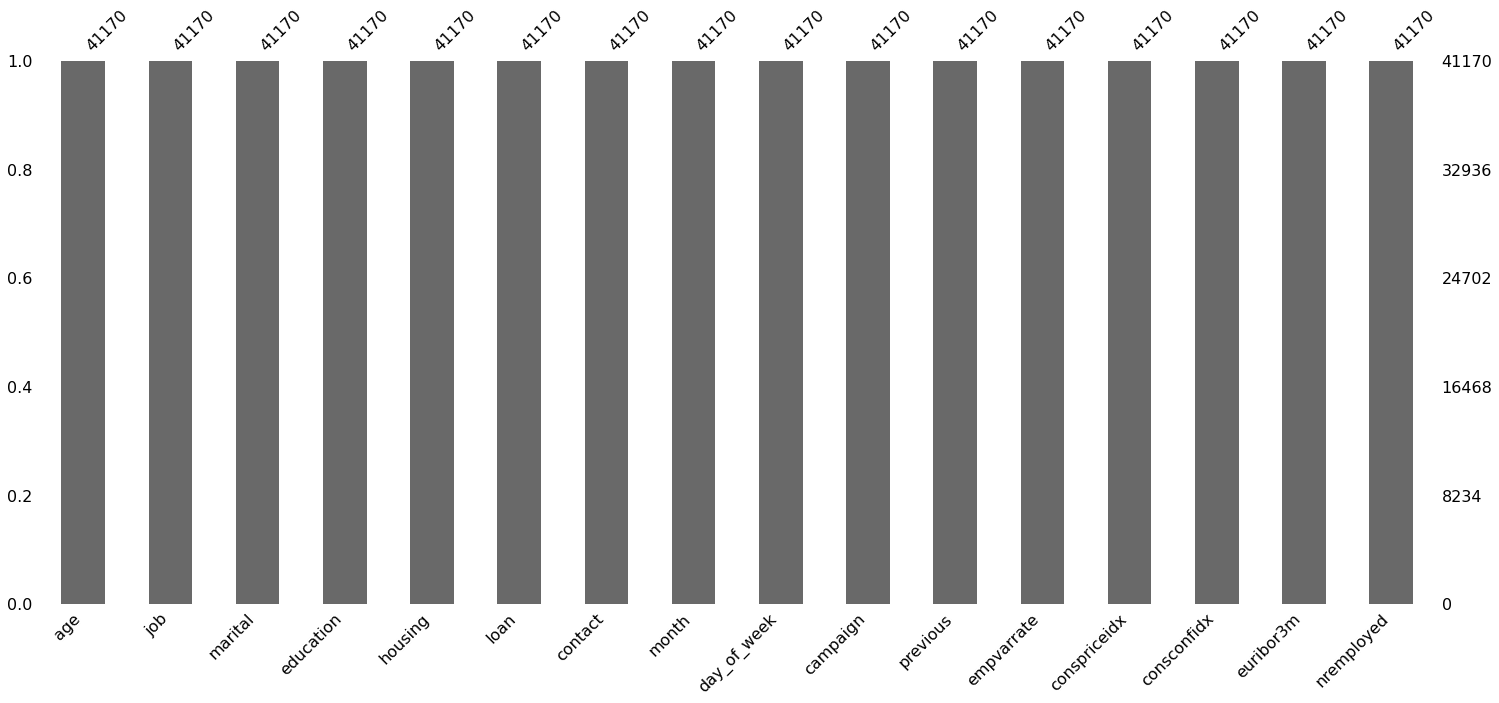

In [44]:
msno.bar(df)

Text(0.5, 0, 'Will the person be interested in bank offer')

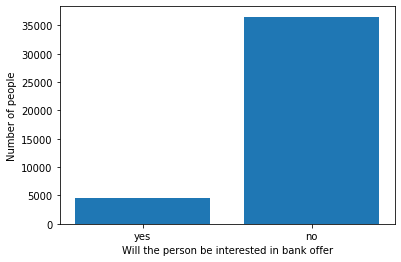

In [45]:
keys = ['yes', 'no']
values = [np.count_nonzero(y==1), np.count_nonzero(y==0)]
plt.bar(keys, values)
plt.ylabel("Number of people")
plt.xlabel("Will the person be interested in bank offer")

Jak widać, będziemy tu mieli do czynienia z problemem klasyfikacji niezbalansowanej. Na szczęście funkcja kosztu w regresji logistycznej pozwala na dodanie **wag klas (class weights)**, aby przypisać większą wagę interesującej nas klasie pozytywnej. Scikit-learn dla wartości `class_weights="balanced"` obliczy wagi odwrotnie proporcjonalne do częstości danej klasy w zbiorze.

**Zadanie 9 (1 punkt)**

*Podział i preprocessing danych*

1. Dokonaj podziału zbioru na treningowy i testowy w proporcjach 75%-25%. Pamiętaj o użyciu podziału ze stratyfikacją (argument `stratify`), aby zachować proporcje klas. Ustaw `random_state=0`.
2. Stwórz `ColumnTransformer`, przetwarzający zmienne kategoryczne za pomocą `OneHotEncoder` (teraz już nie musimy robić `drop="first"`), a numeryczne za pomocą `StandardScaler`. Zaaplikuj go do odpowiednich kolumn.


In [46]:
categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=0, stratify=y
)

In [47]:
from sklearn.preprocessing import StandardScaler

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

column_transformer.fit(X_train)

X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

**Zadanie 10 (2.5 punktu)**

*Trening, tuning i analiza modeli*

1. Wytrenuj podstawowy model regresji logistycznej z użyciem `LogisticRegression`. Użyj wag klas (`class_weights="balanced"`). Przetestuj model, wypisując AUROC w procentach. **Uwaga:** Scikit-learn domyślnie stosuje tutaj regularyzację L2, więc przekaż `penalty="None"`.
2. Dokonaj tuningu modelu z regularyzacją L2 za pomocą `LogisticRegressionCV`:
  - sprawdź 100 wartości, wystarczy podać liczbę do `Cs`
  - użyj 5-krotnej walidacji skrośnej
  - wybierz najlepszy model według metryki AUROC (parametr `scoring`)
  - pamiętaj o `class_weights="balanced"` i `random_state=0`
  - użyj `n_jobs=-1` dla przyspieszenia obliczeń
  - przetestuj model, wypisując AUROC w procentach
  - **uwaga:** Scikit-learn stosuje tutaj konwencję, gdzie parametr `C` to odwrotność siły regularyzacji - im mniejszy, tym silniejsza regularyzacja.
3. Dokonaj analogicznego tuningu, ale dla regularyzacji L1. Użyj solwera SAGA. Przetestuj model, wypisując AUROC w procentach.
4. Dokonaj analizy wytrenowanych modeli:
  - narysuj poziomy wykres słupkowy 10 najważniejszych cech przy użyciu regularyzacji L2, pamiętaj o opisaniu nazw cech, osi i tytule; zwróć uwagę, że wektor współczynników musi być jednowymiarowy
  - wypisz, ile procent cech zostało wyeliminowanych przy użyciu regularyzacji L1, oraz wypisz posortowaną listę nazw tych cech
  - dokonaj interpretacji 2 wybranych cech spośród najlepszych oraz 2 wybranych spośród tych wyeliminowanych - czy ma to twoim zdaniem sens?
  - oblicz AUROC na zbiorze treningowym modelu bez żadnej regularyzacji i porównaj go z wynikiem testowym; czy występuje tutaj overfitting?
  - czy twoim zdaniem tworzenie modeli z regularyzacją ma sens w tym przypadku?

In [48]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(penalty="none", class_weight="balanced")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
auroc = roc_auc_score(y_test, y_pred)
print(f"AUROC: {auroc*100:.2f}%")

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


AUROC: 71.59%


In [49]:
lrcv_l2 = LogisticRegressionCV(Cs=100, cv=5, scoring="roc_auc", penalty="l2", class_weight="balanced", random_state=0, n_jobs=-1)
lrcv_l2.fit(X_train, y_train)
y_pred_l2 = lrcv_l2.predict(X_test)
auroc_l2 = roc_auc_score(y_test, y_pred_l2)
print(f"AUROC (L2 tuning): {auroc_l2*100:.2f}%")

AUROC (L2 tuning): 71.53%


In [50]:
lrcv_l1 = LogisticRegressionCV(Cs=100, cv=5, scoring="roc_auc", penalty="l1", class_weight="balanced", random_state=0, n_jobs=-1, solver='saga')
lrcv_l1.fit(X_train, y_train)
y_pred_l1 = lrcv_l1.predict(X_test)
auroc_l1 = roc_auc_score(y_test, y_pred_l1)
print(f"AUROC (L1 tuning): {auroc_l1*100:.2f}%")

AUROC (L1 tuning): 71.07%


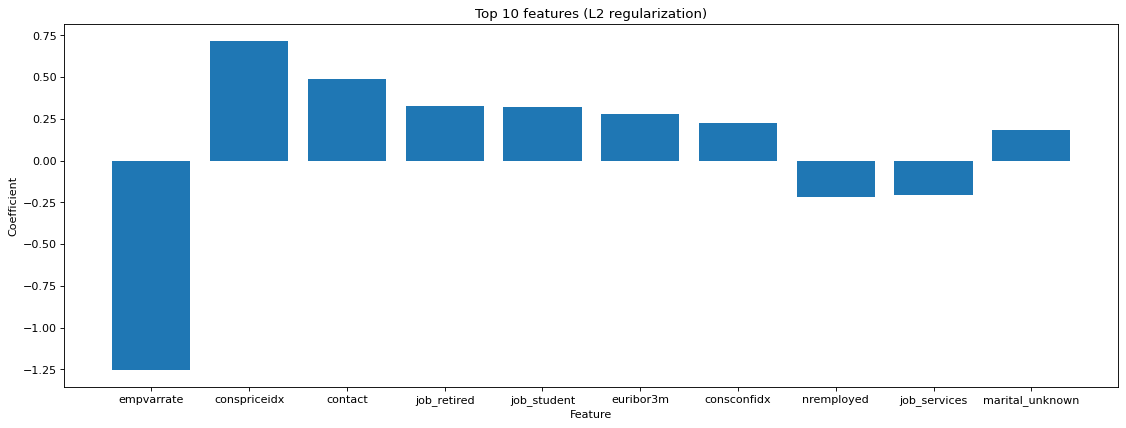

In [51]:
from matplotlib.pyplot import figure

figure(figsize=(17, 6), dpi=80)

feature_names = column_transformer.get_feature_names_out()
feature_names = [s.replace('cat__', '') for s in feature_names]
feature_names = [s.replace('num__', '') for s in feature_names]
feature_names = pd.Series(feature_names)

coefs = lrcv_l2.coef_[0]
top_coefs = np.argsort(np.abs(coefs))[::-1][:10]
plt.bar(range(10), coefs[top_coefs])
plt.xticks(range(10), [feature_names[i] for i in top_coefs])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 10 features (L2 regularization)')
plt.show()

In [52]:
eliminated_features = np.sum(lrcv_l1.coef_[0] == 0) / len(lrcv_l1.coef_[0]) * 100
zero_features = np.argwhere(lrcv_l1.coef_[0] == 0)[:-1].flatten()
zero_features_names = feature_names[zero_features]
print(f"Percentage of eliminated features: {eliminated_features:.2f}%")
print(f"Eliminated features: {zero_features_names}")

Percentage of eliminated features: 45.95%
Eliminated features: 0            job_admin.
2      job_entrepreneur
3         job_housemaid
4        job_management
6     job_self-employed
9        job_technician
10       job_unemployed
11          job_unknown
12     marital_divorced
15      marital_unknown
21      housing_unknown
22          housing_yes
23              loan_no
24         loan_unknown
25             loan_yes
26                  age
dtype: object


In [54]:
train_pred = lr.predict(X_train)

auroc_train = roc_auc_score(y_train, train_pred)
print(f"AUROC (without regularization) on training set: {auroc_train*100:.2f}%")

AUROC (without regularization) on training set: 72.38%


Interpretacja 2 ważnych cech:


*   empvarrate - zmienność pracy, wpływa negatywnie, nic dziwnego, że ktoś nie chce lokaty skoro nie ma stałego źródła dochodów(nie ma czego wpłacać na lokatę), może też potrzebować gotówki w danym czasie, więc nie będzie chciał jej wpłacać na lokatę.
*   job_student - studenci często są zainteresowani lokatami studenckimi, bo zwykle mają dobre warunki umowy

Interpretacja 2 nieważnych cech:


*   loan - wszystkie informacje dotyczące posiadania kredytu są "unrelevant" w tym przypadku, być może jest to cecha zupełnie niepowiązana
*   housing - wszystkie informacje dotyczące posiadania kredytu na dom są "unrelevant" w tym przypadku, być może jest to cecha zupełnie niepowiązana

AUROC dla zbioru treningowego jest rzeczywiście trochę wyższy niż dla zbioru testowego, ale różnica wynosi tylko 1%, więc nie nazwałbym tego overfittingiem.

Moim zdaniem regularyzacja nie poprawia w znaczącym stopniu skuteczności modelu różnica niecałego procenta dla AUROC, jak na tak prostu model zwykła regresja logistyczna dobrze sobie radzi, więc nie potrzeba używać regularyzacji




**Zadanie 11 (1.5 punktu)**

*Dodanie cech wielomianowych do regresji logistycznej*

1. Stwórz nowy pipeline do przetwarzania danych do regresji logistycznej, dodając `PolynomialFeatures` do zmiennych numerycznych przed standaryzacją. Wygeneruj cechy o stopniu 2, interakcje oraz potęgi, nie generuj interceptu.
2. Wytrenuj model regresji logistycznej bez regularyzacji na takim powiększonym zbiorze. Wypisz AUROC treningowy oraz testowy w procentach.
3. Zdecyduj, czy jest sens tworzyć modele z regularyzacją. Jeżeli tak, to wytrenuj i dokonaj tuningu takich modeli. Jeżeli nie, to uzasadnij czemu.

## Zadanie dodatkowe (3 punkty)

Z formalnego, statystycznego punktu widzenia regresja liniowa czyni szereg założeń ([Wikipedia](https://en.wikipedia.org/wiki/Linear_regression#Assumptions)):
1. Liniowość - relacja w danych może być reprezentowana jako `y=Xw`.
2. Normalność błędów - błędy (rezydua) mają rozkład normalny, wycentrowany na zerze.
3. Homoskedastyczność (stała wariancja) - wariancja błędu nie zależy od wartości docelowych `y`. Innymi słowy, nasz błąd będzie w przybliżeniu miał podobny "rozrzut" dla małych i dużych wartości `y`.
4. Niezależność błędów - błąd i `y` są niezależne (w sensie statystycznym). Innymi słowy, nie ma między nimi bezpośredniej relacji. Jeżeli nie pracujemy z szeregami czasowymi, to to założenie po prostu jest spełnione.
5. Brak współliniowości zmiennych - nie ma idealnej korelacji cech.

Testowanie tych własności nie zawsze jest oczywiste, a w szczególności Scikit-learn oferuje tutaj dość mało opcji, bo pochodzą one głównie z tradycyjnej statystyki.

1. Liniowość:
  - numerycznie: wysoki współczynnik dopasowania modelu $R^2$ na zbiorze treningowym, niski błąd (RMSE) na zbiorze treningowym oraz testowym
  - testem statystycznym: [Rainbow test](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.linear_rainbow.html) lub [Harvey Collier test](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.linear_harvey_collier.html)
  - graficznie: możliwe kiedy mamy 1/2 zmienne i da się narysować wykres zmiennej zależnej względem cech
2. Normalność błędów:
  - graficznie: robimy histogram rezyduów, powinien mieć kształt rozkładu normalnego i być wycentrowany na zerze
  - testem statystycznym: [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test), [Omnibus normality test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)
3. Homoskedastyczność:
  - graficznie: robimy scatter plot rezyduów dla wartości przewidywanych od najmniejszej do największej, nie powinno być na nim żadnych widocznych wzorców czy kształtów; [przykład 1](https://towardsdatascience.com/multivariant-linear-regression-e636a4f99b40), [przykład 2](https://www.vexpower.com/brief/homoskedasticity)
  - testem statystycznym: [Breusch–Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) lub [Goldfeld-Quandt test](https://en.wikipedia.org/wiki/Goldfeld%E2%80%93Quandt_test)
4. Niezależność błędów - nie omawiam, bo dotyczy tylko szeregów czasowych.
5. Brak współliniowości zmiennych: numerycznie, sprawdzić korelacje zmiennych, lub współczynnik uwarunkowania macierzy `X`


W ramach zadania wytrenuj model regresji liniowej dla zbioru danych Ames Housing z użyciem biblioteki Statsmodels: [OLS docs](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html), [OLS](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html), [Regression diagnostics](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html). Wytrenuj najpierw model bez regularyzacji, a następnie z regularyzacją L2 oraz L1. Nie przeprowadzaj tuningu, użyj tych wartości siły regularyzacji, które wyznaczyliśmy wcześniej.

Przetestuj założenia za pomocą testów statystycznych: Harvey Collier, Jarque-Bera, Breusch–Pagan. Współliniowość zmiennych zweryfikuj z użyciem współczynnika uwarunkowania. Zastosuj poziom istotności $\alpha=0.05$.

Czy założenia są spełnione w przypadku podstawowego modelu i/lub modeli z regularyzacją? Czy modele regularyzowane w lepszym stopniu spełniają założenia?